In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import autocast, GradScaler  # Updated import
import numpy as np
from data_loader import get_loaders, get_dataset_statistics
import os
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score
from scipy import ndimage
from tqdm import tqdm

# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Constants (adjust as needed)
IMG_SIZE = 256
BATCH_SIZE = 128
NUM_EPOCHS = 100
MIN_AREA = 100  # Minimum area for connected component filtering

Using device: cuda


In [2]:
class DoubleConv(nn.Module):
    """(Conv3x3 -> GroupNorm -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None, groups=8):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
            
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.GroupNorm(groups, mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(groups, out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class DenseUNet(nn.Module):
    def __init__(self, pretrained=True, dropout_rate=0.1):
        super(DenseUNet, self).__init__()
        
        # Load pretrained DenseNet121 with updated torchvision syntax
        weights = models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None
        densenet = models.densenet121(weights=weights)
        
        # Encoder parts
        self.initial = densenet.features.conv0
        self.norm0 = densenet.features.norm0
        self.relu0 = densenet.features.relu0
        self.pool0 = densenet.features.pool0
        
        self.denseblock1 = densenet.features.denseblock1
        self.transition1 = densenet.features.transition1
        
        self.denseblock2 = densenet.features.denseblock2
        self.transition2 = densenet.features.transition2
        
        self.denseblock3 = densenet.features.denseblock3
        self.transition3 = densenet.features.transition3
        
        self.denseblock4 = densenet.features.denseblock4
        self.norm5 = densenet.features.norm5
        
        # Get the actual number of output channels for each block
        # DenseNet121 channel sizes: 64, 256, 512, 1024, 1024
        self.channel_sizes = [64, 256, 512, 1024, 1024]
        
        # Decoder with correct channel dimensions and proper upsampling
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = DoubleConv(self.channel_sizes[4] + self.channel_sizes[3], 512)
        self.dropout1 = nn.Dropout2d(dropout_rate)
        
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv2 = DoubleConv(512 + self.channel_sizes[2], 256)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv3 = DoubleConv(256 + self.channel_sizes[1], 128)
        self.dropout3 = nn.Dropout2d(dropout_rate)
        
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv4 = DoubleConv(128 + self.channel_sizes[0], 64)
        
        # Final upsampling to get back to original input size
        self.final_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, x):
        # Store original input size for final upsampling
        original_size = x.shape[2:]
        
        # Convert 1 channel to 3 channels for pretrained encoder
        x = x.repeat(1, 3, 1, 1)
        
        # Encoder
        x0 = self.initial(x)  # 256×256 -> 128×128
        x0 = self.norm0(x0)
        x0 = self.relu0(x0)
        x1 = self.pool0(x0)   # 128×128 -> 64×64
        
        x1 = self.denseblock1(x1)  # 64×64
        x2 = self.transition1(x1)  # 64×64 -> 32×32
        
        x2 = self.denseblock2(x2)  # 32×32
        x3 = self.transition2(x2)  # 32×32 -> 16×16
        
        x3 = self.denseblock3(x3)  # 16×16
        x4 = self.transition3(x3)  # 16×16 -> 8×8
        
        x4 = self.denseblock4(x4)  # 8×8
        x5 = self.norm5(x4)        # 8×8
        
        # Decoder with skip connections
        d1 = self.up1(x5)          # 8×8 -> 16×16
        d1 = torch.cat([d1, x3], dim=1)
        d1 = self.conv1(d1)
        d1 = self.dropout1(d1)
        
        d2 = self.up2(d1)          # 16×16 -> 32×32
        d2 = torch.cat([d2, x2], dim=1)
        d2 = self.conv2(d2)
        d2 = self.dropout2(d2)
        
        d3 = self.up3(d2)          # 32×32 -> 64×64
        d3 = torch.cat([d3, x1], dim=1)
        d3 = self.conv3(d3)
        d3 = self.dropout3(d3)
        
        d4 = self.up4(d3)          # 64×64 -> 128×128
        d4 = torch.cat([d4, x0], dim=1)
        d4 = self.conv4(d4)
        
        # Final upsampling to original input size
        d5 = self.final_upsample(d4)  # 128×128 -> 256×256
        output = self.final_conv(d5)
        
        return output

In [3]:
class DiceBCELoss(nn.Module):
    def __init__(self, alpha=0.5, smooth=1e-6):
        super(DiceBCELoss, self).__init__()
        self.alpha = alpha
        self.smooth = smooth
        self.bce = nn.BCEWithLogitsLoss()
        
    def forward(self, logits, targets):
        # BCE loss
        bce_loss = self.bce(logits, targets)
        
        # Dice loss
        probs = torch.sigmoid(logits)
        num = targets.size(0)
        probs = probs.view(num, -1)
        targets = targets.view(num, -1)
        
        intersection = (probs * targets).sum(1)
        dice = (2. * intersection + self.smooth) / (probs.sum(1) + targets.sum(1) + self.smooth)
        dice_loss = 1 - dice.mean()
        
        return self.alpha * bce_loss + (1 - self.alpha) * dice_loss

def dice_coeff(logits, targets, threshold=0.5, smooth=1e-6):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    
    num = targets.size(0)
    preds = preds.view(num, -1)
    targets = targets.view(num, -1)
    
    intersection = (preds * targets).sum(1)
    dice = (2. * intersection + smooth) / (preds.sum(1) + targets.sum(1) + smooth)
    return dice.mean()

def iou_coeff(logits, targets, threshold=0.5, smooth=1e-6):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    
    num = targets.size(0)
    preds = preds.view(num, -1)
    targets = targets.view(num, -1)
    
    intersection = (preds * targets).sum(1)
    union = preds.sum(1) + targets.sum(1) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def calculate_metrics(logits, targets, threshold=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float().cpu().numpy()
    targets = targets.cpu().numpy()
    
    # Flatten for sklearn metrics
    preds_flat = preds.reshape(-1)
    targets_flat = targets.reshape(-1)
    
    precision = precision_score(targets_flat, preds_flat, zero_division=0)
    recall = recall_score(targets_flat, preds_flat, zero_division=0)
    accuracy = accuracy_score(targets_flat, preds_flat)
    
    return precision, recall, accuracy

In [4]:
# Modify the freeze_encoder function to handle DataParallel
def freeze_encoder(model):
    """Freeze all encoder parameters"""
    # Get the actual model (handles DataParallel wrapper)
    actual_model = model.module if isinstance(model, nn.DataParallel) else model
    
    for param in actual_model.initial.parameters():
        param.requires_grad = False
    for param in actual_model.norm0.parameters():
        param.requires_grad = False
    for param in actual_model.denseblock1.parameters():
        param.requires_grad = False
    for param in actual_model.transition1.parameters():
        param.requires_grad = False
    for param in actual_model.denseblock2.parameters():
        param.requires_grad = False
    for param in actual_model.transition2.parameters():
        param.requires_grad = False
    for param in actual_model.denseblock3.parameters():
        param.requires_grad = False
    for param in actual_model.transition3.parameters():
        param.requires_grad = False
    for param in actual_model.denseblock4.parameters():
        param.requires_grad = False
    for param in actual_model.norm5.parameters():
        param.requires_grad = False

# Modify the unfreeze_block function
def unfreeze_block(model, block_name):
    """Unfreeze a specific block"""
    # Get the actual model (handles DataParallel wrapper)
    actual_model = model.module if isinstance(model, nn.DataParallel) else model
    
    if block_name == 'denseblock4':
        for param in actual_model.denseblock4.parameters():
            param.requires_grad = True
    elif block_name == 'denseblock3':
        for param in actual_model.denseblock3.parameters():
            param.requires_grad = True
    elif block_name == 'denseblock2':
        for param in actual_model.denseblock2.parameters():
            param.requires_grad = True
    elif block_name == 'denseblock1':
        for param in actual_model.denseblock1.parameters():
            param.requires_grad = True
    elif block_name == 'conv0':
        for param in actual_model.initial.parameters():
            param.requires_grad = True
        for param in actual_model.norm0.parameters():
            param.requires_grad = True

# Modify the get_parameter_groups function
def get_parameter_groups(model, base_lr=1e-4):
    """Create parameter groups with different learning rates"""
    # Get the actual model (handles DataParallel wrapper)
    actual_model = model.module if isinstance(model, nn.DataParallel) else model
    
    # Learning rate mapping
    lr_mapping = {
        'denseblock4': 1e-4,
        'denseblock3': 5e-5,
        'denseblock2': 1e-5,
        'denseblock1': 1e-6,
        'conv0': 1e-6,
        'decoder': 1e-4,
        'head': 1e-4
    }
    
    # Parameter groups
    param_groups = []
    param_names_in_groups = set()
    
    # Add encoder parameters with specific learning rates
    # denseblock4
    denseblock4_params = []
    for name, param in actual_model.denseblock4.named_parameters():
        if param.requires_grad:
            denseblock4_params.append(param)
            param_names_in_groups.add(name)
    if denseblock4_params:
        param_groups.append({'params': denseblock4_params, 'lr': lr_mapping['denseblock4']})
    
    # denseblock3
    denseblock3_params = []
    for name, param in actual_model.denseblock3.named_parameters():
        if param.requires_grad:
            denseblock3_params.append(param)
            param_names_in_groups.add(name)
    if denseblock3_params:
        param_groups.append({'params': denseblock3_params, 'lr': lr_mapping['denseblock3']})
    
    # denseblock2
    denseblock2_params = []
    for name, param in actual_model.denseblock2.named_parameters():
        if param.requires_grad:
            denseblock2_params.append(param)
            param_names_in_groups.add(name)
    if denseblock2_params:
        param_groups.append({'params': denseblock2_params, 'lr': lr_mapping['denseblock2']})
    
    # denseblock1
    denseblock1_params = []
    for name, param in actual_model.denseblock1.named_parameters():
        if param.requires_grad:
            denseblock1_params.append(param)
            param_names_in_groups.add(name)
    if denseblock1_params:
        param_groups.append({'params': denseblock1_params, 'lr': lr_mapping['denseblock1']})
    
    # conv0 and norm0
    conv0_params = []
    for name, param in actual_model.initial.named_parameters():
        if param.requires_grad:
            conv0_params.append(param)
            param_names_in_groups.add(name)
    for name, param in actual_model.norm0.named_parameters():
        if param.requires_grad:
            conv0_params.append(param)
            param_names_in_groups.add(name)
    if conv0_params:
        param_groups.append({'params': conv0_params, 'lr': lr_mapping['conv0']})
    
    # Add decoder parameters (everything not in encoder)
    decoder_params = []
    head_params = []
    
    for name, param in actual_model.named_parameters():
        if param.requires_grad and name not in param_names_in_groups:
            if 'final_conv' in name:
                head_params.append(param)
            else:
                decoder_params.append(param)
    
    if decoder_params:
        param_groups.append({'params': decoder_params, 'lr': lr_mapping['decoder']})
    
    if head_params:
        param_groups.append({'params': head_params, 'lr': lr_mapping['head']})
    
    return param_groups
    
def save_checkpoint(state, filename="best_dense_unet.pth"):
    torch.save(state, filename)

def load_checkpoint(model, optimizer=None, scheduler=None, scaler=None, filename="best_dense_unet.pth"):
    try:
        checkpoint = torch.load(filename)
        state_dict = checkpoint['state_dict']
        
        # Try loading directly first
        try:
            if isinstance(model, nn.DataParallel):
                model.module.load_state_dict(state_dict)
            else:
                model.load_state_dict(state_dict)
                
        except RuntimeError:
            # If direct loading fails, try handling the module prefix mismatch
            if any(key.startswith('module.') for key in state_dict.keys()):
                # Remove 'module.' prefix for single GPU model
                new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
            else:
                # Add 'module.' prefix for DataParallel model
                new_state_dict = {'module.' + k: v for k, v in state_dict.items()}
            
            if isinstance(model, nn.DataParallel):
                model.module.load_state_dict(new_state_dict)
            else:
                model.load_state_dict(new_state_dict)
        
        # Load optimizer, scheduler, scaler if provided
        if optimizer and 'optimizer' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
        if scheduler and 'scheduler' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler'])
        if scaler and 'scaler' in checkpoint:
            scaler.load_state_dict(checkpoint['scaler'])
        
        epoch = checkpoint.get('epoch', 0)
        best_metric = checkpoint.get('best_metric', 0.0)
        
        print(f"✓ Successfully loaded checkpoint from epoch {epoch}")
        return epoch, best_metric
        
    except Exception as e:
        print(f"❌ Error loading checkpoint: {e}")
        return 0, 0.0

def connected_component_postprocessing(mask, min_area=100):
    """Remove small connected components from the mask"""
    labeled, num_components = ndimage.label(mask)
    component_sizes = np.bincount(labeled.ravel())
    
    # Remove small components
    too_small = component_sizes < min_area
    too_small_mask = too_small[labeled]
    mask[too_small_mask] = 0
    
    return mask

In [5]:
# Initialize model
model = DenseUNet(pretrained=True, dropout_rate=0.1)

# Use DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)

# Freeze encoder initially
freeze_encoder(model)

# Loss function
criterion = DiceBCELoss(alpha=0.5)

# Optimizer with parameter groups
optimizer = optim.AdamW(get_parameter_groups(model), weight_decay=1e-4)

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-7)

# GradScaler for mixed precision with updated syntax
scaler = GradScaler('cuda')  # Updated syntax

# TensorBoard writer
writer = SummaryWriter(f'runs/lung_segmentation_{datetime.now().strftime("%Y%m%d_%H%M%S")}')

checkpoint_path = "best_dense_unet.pth"
if os.path.exists(checkpoint_path):
    print("Loading checkpoint...")
    start_epoch, best_dice = load_checkpoint(model, optimizer, scheduler, scaler, checkpoint_path)
    print(f"Resuming from epoch {start_epoch} with best Dice: {best_dice:.4f}")
else:
    print("No checkpoint found. Starting from scratch.")
    start_epoch = 0
    best_dice = 0.0
    
global_patience = 20
patience_counter = 0

# Unfreezing parameters
delta_threshold = 5e-3
patience_unfreeze = 3
consecutive_small_improve = 0
last_metric = 0.0
unfreeze_queue = ['denseblock4', 'denseblock3', 'denseblock2', 'denseblock1', 'conv0']

# Training history
history = {
    'train_loss': [], 'val_loss': [], 
    'val_dice': [], 'val_iou': [],
    'val_precision': [], 'val_recall': [], 'val_accuracy': []
}

# Get dataloaders
train_loader, val_loader, test_loader = get_loaders(
    data_dir='.',
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count()-1,  # Set to 0 to avoid tqdm issues, can change to os.cpu_count()-1 later
    use_weighted_sampler=False,
    pin_memory=True,
    drop_last=False,
    persistent_workers=True  # Set to False when num_workers=0
)



# unfreezing layers manually

block_to_unfreeze = unfreeze_queue.pop(0)
unfreeze_block(model, block_to_unfreeze)
print(f'Unfreezing {block_to_unfreeze}')

block_to_unfreeze = unfreeze_queue.pop(0)
unfreeze_block(model, block_to_unfreeze)
print(f'Unfreezing {block_to_unfreeze}')




for epoch in range(start_epoch, NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    
    
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}] Training", leave=False)
    
    for images, masks in train_loop:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        
        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, masks)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item() * images.size(0)
        
        
        train_loop.set_postfix(loss=loss.item())
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    val_iou = 0.0
    val_precision = 0.0
    val_recall = 0.0
    val_accuracy = 0.0
    
    # tqdm روی val_loader
    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}] Validation", leave=False)
    
    with torch.no_grad():
        for images, masks in val_loop:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            
            # Calculate metrics
            dice = dice_coeff(outputs, masks).item()
            iou = iou_coeff(outputs, masks).item()
            precision, recall, accuracy = calculate_metrics(outputs, masks)
            
            val_dice += dice * images.size(0)
            val_iou += iou * images.size(0)
            val_precision += precision * images.size(0)
            val_recall += recall * images.size(0)
            val_accuracy += accuracy * images.size(0)
            
            
            val_loop.set_postfix(
                loss=loss.item(),
                dice=f"{dice:.4f}",
                iou=f"{iou:.4f}"
            )
    
    # Calculate averages
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_dice = val_dice / len(val_loader.dataset)
    val_iou = val_iou / len(val_loader.dataset)
    val_precision = val_precision / len(val_loader.dataset)
    val_recall = val_recall / len(val_loader.dataset)
    val_accuracy = val_accuracy / len(val_loader.dataset)
    
    # Update learning rate
    scheduler.step(val_dice)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_accuracy'].append(val_accuracy)
    
    # Print statistics 
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")
    print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    # TensorBoard logging
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Metrics/dice', val_dice, epoch)
    writer.add_scalar('Metrics/iou', val_iou, epoch)
    writer.add_scalar('Metrics/precision', val_precision, epoch)
    writer.add_scalar('Metrics/recall', val_recall, epoch)
    writer.add_scalar('Metrics/accuracy', val_accuracy, epoch)
    
    # Check for improvement
    delta = val_dice - last_metric
    last_metric = val_dice
    
    if val_dice > best_dice:
        best_dice = val_dice
        patience_counter = 0

        if isinstance(model, nn.DataParallel):
            state_dict = model.module.state_dict()
        else:
            state_dict = model.state_dict()
        
        # Save checkpoint
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'scaler': scaler.state_dict(),
            'best_metric': best_dice,
        })
        print(f"Checkpoint Saved at Dice={best_dice}.")
    else:
        patience_counter += 1
    
    # Check for early stopping
    if patience_counter >= global_patience:
        print(f'Early stopping at epoch {epoch+1}')
        break
    
    # Progressive unfreezing logic
    if delta < delta_threshold:
        consecutive_small_improve += 1
    else:
        consecutive_small_improve = 0
    
    if (consecutive_small_improve >= patience_unfreeze and 
        epoch > 0 and  # Ensure at least one epoch has passed
        unfreeze_queue):
        
        # Unfreeze the next block
        block_to_unfreeze = unfreeze_queue.pop(0)
        unfreeze_block(model, block_to_unfreeze)
        print(f'Unfreezing {block_to_unfreeze}')
        
        # Reset optimizer, scheduler, and scaler
        # optimizer = optim.AdamW(get_parameter_groups(model), weight_decay=1e-4) #ValueError: some parameters appear in more than one parameter group
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-7)
        scaler = GradScaler('cuda')  # Updated syntax
        
        # Reset counters
        consecutive_small_improve = 0

# Close TensorBoard writer
writer.close()

Loading checkpoint...
✓ Successfully loaded checkpoint from epoch 26
Resuming from epoch 26 with best Dice: 0.9826



KeyboardInterrupt



In [5]:

train_loader, val_loader, test_loader = get_loaders(
    data_dir='.',
    batch_size=16,
    num_workers=0,  # Set to 0 to avoid tqdm issues, can change to os.cpu_count()-1 later
    use_weighted_sampler=False,
    pin_memory=True,
    drop_last=False,
    persistent_workers=False  # Set to False when num_workers=0
)

# Load best model
model = DenseUNet(pretrained=False).to(device)
epoch, best_metric = load_checkpoint(model, filename="best_dense_unet.pth")
print(f"Loaded checkpoint from epoch {epoch} with Dice: {best_metric:.4f}")

# Evaluate on test set
model.eval()
test_dice = 0.0
test_iou = 0.0
test_precision = 0.0
test_recall = 0.0
test_accuracy = 0.0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        
        outputs = model(images)
        
        # Apply post-processing
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(np.uint8)
        
        # Apply connected component post-processing
        for i in range(preds.shape[0]):
            preds[i, 0] = connected_component_postprocessing(preds[i, 0], min_area=MIN_AREA)
        
        # Convert back to tensor for metric calculation
        preds = torch.from_numpy(preds).float().to(device)
        
        # Calculate metrics
        test_dice += dice_coeff(preds, masks).item() * images.size(0)
        test_iou += iou_coeff(preds, masks).item() * images.size(0)
        
        precision, recall, accuracy = calculate_metrics(preds, masks)
        test_precision += precision * images.size(0)
        test_recall += recall * images.size(0)
        test_accuracy += accuracy * images.size(0)

# Calculate averages
test_dice = test_dice / len(test_loader.dataset)
test_iou = test_iou / len(test_loader.dataset)
test_precision = test_precision / len(test_loader.dataset)
test_recall = test_recall / len(test_loader.dataset)
test_accuracy = test_accuracy / len(test_loader.dataset)

print("Test Results:")
print(f"Dice: {test_dice:.4f}, IoU: {test_iou:.4f}")
print(f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, Accuracy: {test_accuracy:.4f}")

Dataset Statistics:
Total images: 60911

Dataset Breakdown:
  COVID-19_Radiography: 21165 images
  Infection_Segmentation: 5826 images
  Lung_Segmentation: 33920 images

Size Breakdown:
  img_(299, 299)_mask_(256, 256): 21165 images
  img_(256, 256)_mask_(256, 256): 39746 images
✓ Successfully loaded checkpoint from epoch 26
Loaded checkpoint from epoch 26 with Dice: 0.9826
Test Results:
Dice: 0.9823, IoU: 0.9658
Precision: 0.9835, Recall: 0.9833, Accuracy: 0.9922


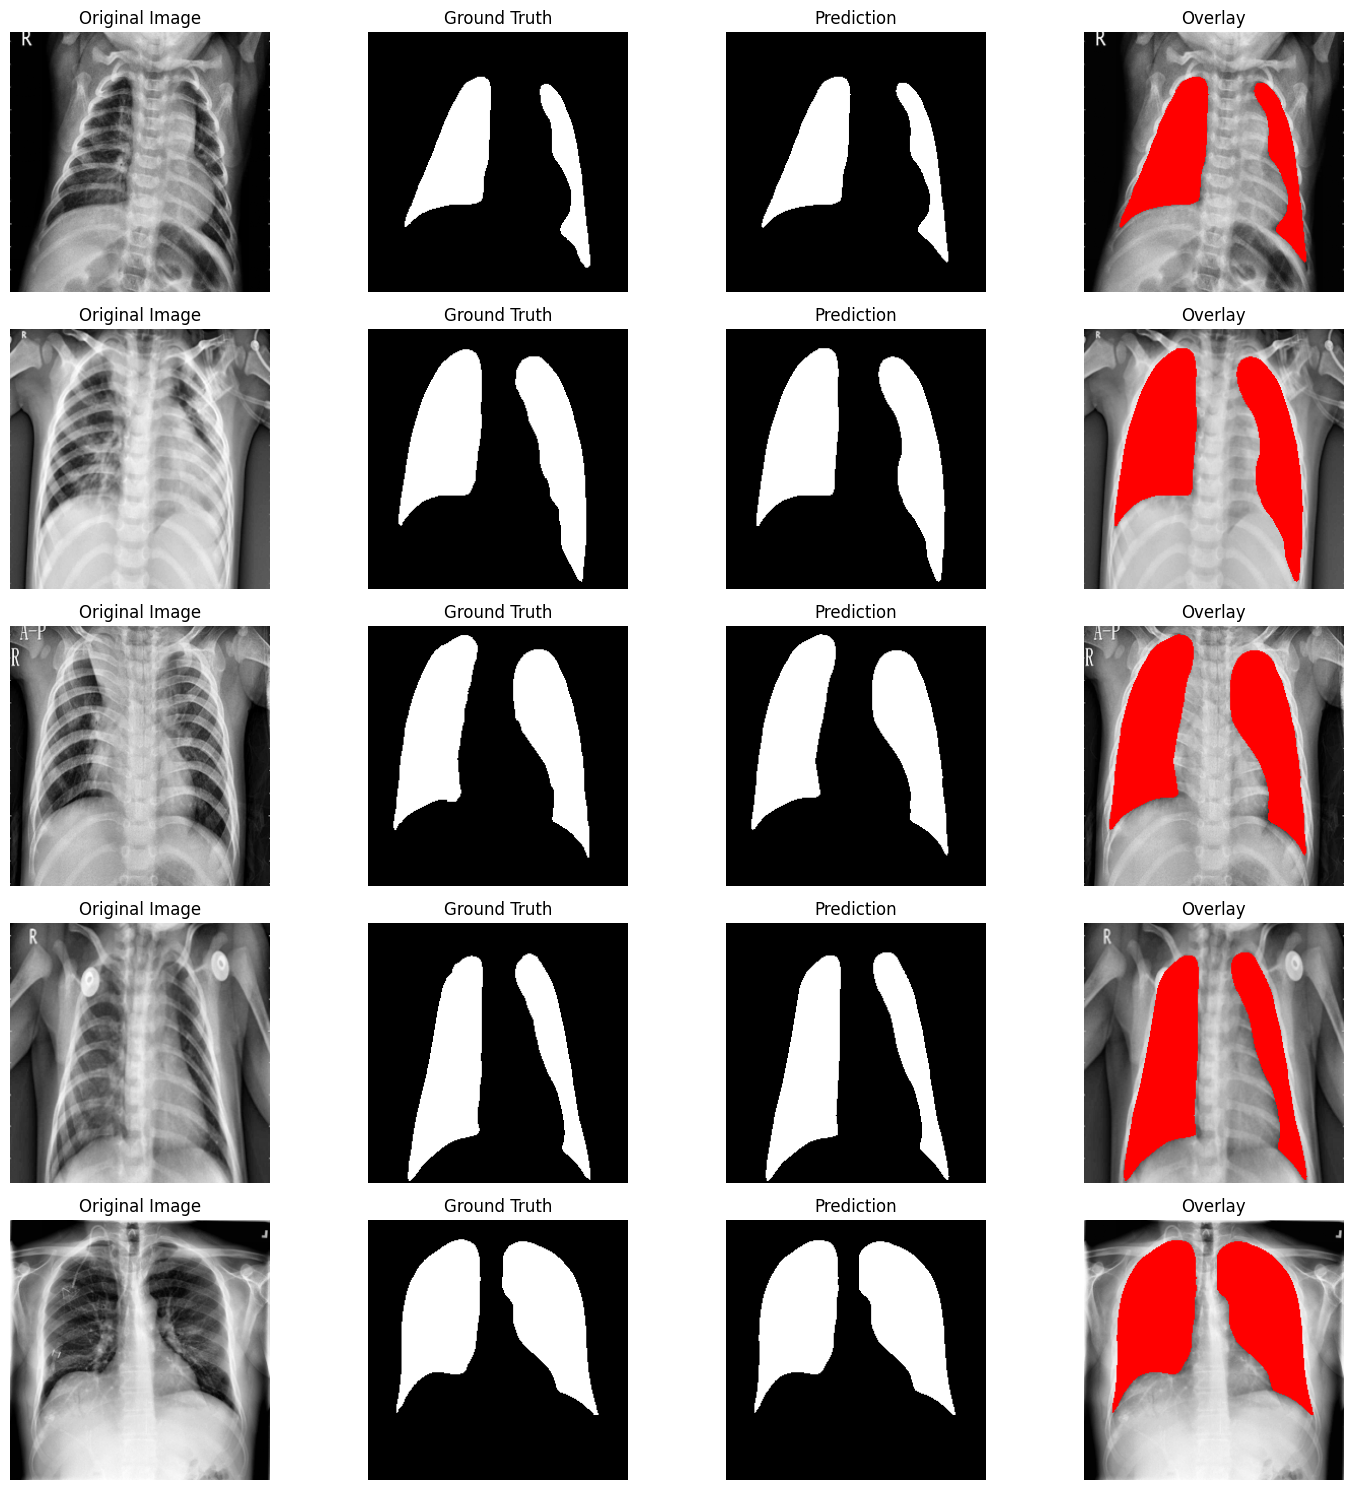

NameError: name 'history' is not defined

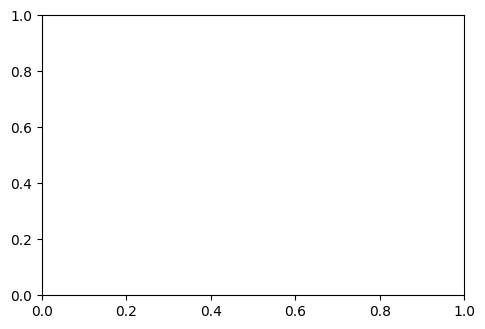

In [6]:
def visualize_predictions(model, dataloader, num_samples=5):
    model.eval()
    images, masks = next(iter(dataloader))
    
    with torch.no_grad():
        outputs = model(images.to(device))
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(np.uint8)
    
    # Apply post-processing
    for i in range(preds.shape[0]):
        preds[i, 0] = connected_component_postprocessing(preds[i, 0], min_area=MIN_AREA)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(15, num_samples*3))
    
    for i in range(num_samples):
        # Original image
        axes[i, 0].imshow(images[i].squeeze(), cmap='gray')
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Ground truth mask
        axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Prediction
        axes[i, 2].imshow(preds[i].squeeze(), cmap='gray')
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
        
        # Overlay
        img_np = images[i].squeeze().numpy()
        pred_np = preds[i].squeeze()
        
        # Create a color overlay (red mask)
        overlay = np.stack([img_np, img_np, img_np], axis=-1)
        overlay[pred_np > 0] = [1, 0, 0]  # Red color for mask
        
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Overlay')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some test samples
visualize_predictions(model, test_loader, num_samples=5)

# Plot training history
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 2)
plt.plot(history['val_dice'], label='Dice')
plt.plot(history['val_iou'], label='IoU')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Validation Metrics')

plt.subplot(2, 2, 3)
plt.plot(history['val_precision'], label='Precision')
plt.plot(history['val_recall'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Precision and Recall')

plt.subplot(2, 2, 4)
plt.plot(history['val_accuracy'], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()